In [1]:
import pandas as pd

Сперва сосчитаем все файлы

In [2]:
smiles = pd.read_csv('smiles.txt', header=None)
smiles.columns = ['smiles']

test_predictions = pd.read_csv('test_predictions.txt', header=None)
test_predictions.columns = ['test_predictions']

test_targets = pd.read_csv('test_targets.txt', header=None)
test_targets.columns = ['test_targets']

Теперь приведем все молекулы в smiles.txt к нормальной форме Chem.MolToSmiles(

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
smiles['mols'] = smiles.smiles.apply(lambda x: Chem.MolFromSmiles(x))
smiles['normal_smiles'] = smiles.mols.apply(lambda x: Chem.MolToSmiles(x, True))

Посмотрим, какие smiles соответствовали одной молекуле 

In [4]:
len(smiles.smiles.unique()), len(smiles.normal_smiles.unique()),

(216, 207)

In [5]:
# для этого создадим единичную колонку для последующей агрегации
smiles['nums'] = 1
# проагрегируем и обнаружим искомую молекулу
agg_smiles = smiles.groupby('normal_smiles').sum().reset_index()
need_mol_smile = agg_smiles.loc[agg_smiles.nums > 1].normal_smiles.item()
need_mol = smiles.loc[smiles.normal_smiles == need_mol_smile].head(1).mols.item()
need_mol.SetProp("_Smile", f"{need_mol_smile}")

нарисуем искомую молекулу

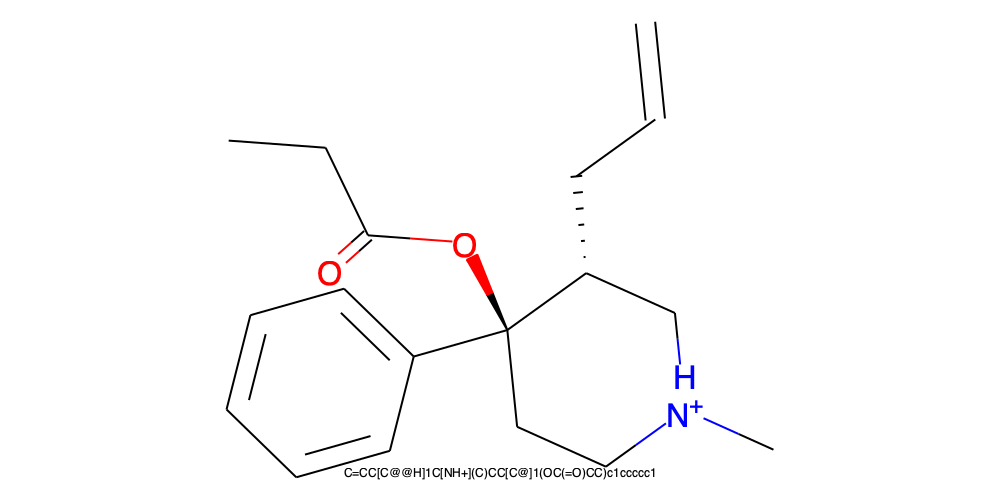

In [6]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([need_mol],molsPerRow=1,subImgSize=(1000,500),legends=[x.GetProp("_Smile") for x in [need_mol]])  

Теперь посчитаем Top-1, Top-5 и Top-10 accuracy для предсказаний ретросинтеза

In [7]:
results = {
    "Top_1" : [],
    "Top_5" : [],
    "Top_10": []
}
for arrs in zip(test_predictions.to_numpy().reshape(5004, 10), test_targets.to_numpy()):
    preds, trues = arrs
    Top_1 = (trues == preds[0]).item()
    Top_5 = trues in preds[:5]
    Top_10 = trues in preds
    
    results["Top_1"].append(Top_1)
    results["Top_5"].append(Top_5)
    results["Top_10"].append(Top_10)
    
Acc_1 = sum(results['Top_1']) / 5004
Acc_5 = sum(results['Top_5']) / 5004
Acc_10 = sum(results['Top_10']) / 5004

In [8]:
print(f'Top-1 : {Acc_1}\nTop-5 : {Acc_5}\nTop-10 : {Acc_10}')

Top-1 : 0.002398081534772182
Top-5 : 0.011990407673860911
Top-10 : 0.01938449240607514
